In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DATA_PATH = '/content/drive/MyDrive/New dataset'

In [3]:
import pandas as pd

class_counts = {}

for class_name in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.endswith('.wav')])
        class_counts[class_name] = count

df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Num_Files'])
df_counts = df_counts.sort_values(by='Num_Files', ascending=False)
print(df_counts)


           Num_Files
Others           525
Gunshots         500
police           454
firetruck        400
ambulance        400


In [4]:
import librosa

durations = []

for class_name in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                try:
                    audio, sr = librosa.load(path, sr=None)
                    duration = librosa.get_duration(y=audio, sr=sr)
                    durations.append({
                        'class': class_name,
                        'duration_sec': duration
                    })
                except Exception as e:
                    print(f"Error loading {path}: {e}")

df_durations = pd.DataFrame(durations)
avg_durations = df_durations.groupby("class")["duration_sec"].agg(['mean', 'min', 'max', 'count']).sort_values(by='mean', ascending=False)
avg_durations


,mean,min,max,count
class,,,,
Others,4.847360,1.037646,60.000000,525
Gunshots,3.910000,1.000000,360.000000,500
firetruck,3.001995,3.000000,3.007982,400
ambulance,3.001871,3.000000,3.018980,400
police,3.000000,3.000000,3.000000,454


In [6]:
import os
import librosa
import soundfile as sf
from tqdm import tqdm

# Input and output folders
INPUT_PATH = "/content/drive/MyDrive/New dataset"      # Replace this
OUTPUT_PATH = "/content/drive/MyDrive/Split_Dataset"               # Where new data will be saved
SAMPLE_RATE = 16000
CHUNK_DURATION = 3  # seconds
CHUNK_SAMPLES = SAMPLE_RATE * CHUNK_DURATION


# Create output directory if not exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Loop through classes and files
for class_name in os.listdir(INPUT_PATH):
    class_path = os.path.join(INPUT_PATH, class_name)
    output_class_path = os.path.join(OUTPUT_PATH, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        if not file.endswith(".wav"):
            continue

        file_path = os.path.join(class_path, file)
        try:
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            duration = librosa.get_duration(y=audio, sr=sr)

            if duration <= CHUNK_DURATION:
                # Copy original file directly if already 3s or less
                sf.write(os.path.join(output_class_path, file), audio, sr)
            else:
                # Split into 3s chunks
                total_chunks = int(len(audio) / CHUNK_SAMPLES)
                for i in range(total_chunks):
                    chunk = audio[i * CHUNK_SAMPLES: (i + 1) * CHUNK_SAMPLES]
                    chunk_filename = f"{os.path.splitext(file)[0]}_part{i+1}.wav"
                    sf.write(os.path.join(output_class_path, chunk_filename), chunk, sr)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

Processing Others: 100%|██████████| 525/525 [00:19<00:00, 27.48it/s]


In [7]:
import pandas as pd
import os

SPLIT_PATH = "/content/drive/MyDrive/Split_Dataset"

class_counts = {}

for class_name in os.listdir(SPLIT_PATH):
    class_path = os.path.join(SPLIT_PATH, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.endswith('.wav')])
        class_counts[class_name] = count

df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Num_Files'])
df_counts = df_counts.sort_values(by='Num_Files', ascending=False)
print(df_counts)


           Num_Files
Gunshots         824
Others           705
police           454
firetruck        400
ambulance        400


In [8]:
import librosa

durations = []

for class_name in os.listdir(SPLIT_PATH):
    class_path = os.path.join(SPLIT_PATH, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                try:
                    audio, sr = librosa.load(path, sr=None)
                    duration = librosa.get_duration(y=audio, sr=sr)
                    durations.append({
                        'class': class_name,
                        'duration_sec': duration
                    })
                except Exception as e:
                    print(f"Error loading {path}: {e}")

import pandas as pd
df_durations = pd.DataFrame(durations)
avg_durations = df_durations.groupby("class")["duration_sec"].agg(['mean', 'min', 'max', 'count']).sort_values(by='mean', ascending=False)
avg_durations


,mean,min,max,count
class,,,,
ambulance,3.000000,3.000000,3.0,400
police,3.000000,3.000000,3.0,454
firetruck,3.000000,3.000000,3.0,400
Others,2.918613,1.037688,3.0,705
Gunshots,2.366505,1.000000,3.0,824


In [9]:
DATA_PATH = "/content/drive/MyDrive/Split_Dataset"

In [12]:
# !pip install audiomentations

import os
import numpy as np
import librosa
import joblib
import random
from audiomentations import Compose, PitchShift, TimeStretch, Gain, Shift
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [26]:
DATA_PATH = "/content/drive/MyDrive/Split_Dataset"
SAMPLE_RATE = 16000
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MELS = 128


In [27]:
AUGMENT = Compose([
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5)
])



In [28]:
def extract_mel_spectrogram(file_path, apply_augment=False):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(audio.shape) > 1:
            audio = librosa.to_mono(audio)
        if len(audio) < SAMPLES_PER_TRACK:
            audio = np.pad(audio, (0, SAMPLES_PER_TRACK - len(audio)))
        else:
            audio = audio[:SAMPLES_PER_TRACK]
        if apply_augment:
            audio = AUGMENT(samples=audio, sample_rate=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db
    except Exception as e:
        print(f"Error: {file_path} | {e}")
        return None


In [29]:
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        X, y = [], []

        for path, label in zip(batch_paths, batch_labels):
            mel = extract_mel_spectrogram(path, apply_augment=self.augment)
            if mel is not None and mel.shape[1] == 94:
                X.append(mel[..., np.newaxis])
                y.append(label)

        if not X:
            print(f"[!] Skipping empty batch {index}")
            return self.__getitem__((index + 1) % self.__len__())

        print(f"[Batch {index}] Loaded {len(X)} valid samples")
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle:
            zipped = list(zip(self.file_paths, self.labels))
            random.shuffle(zipped)
            self.file_paths, self.labels = zip(*zipped)


In [30]:
# valid_counts = {}

# for label in os.listdir(DATA_PATH):
#     count = 0
#     path = os.path.join(DATA_PATH, label)
#     for file in os.listdir(path):
#         if file.endswith('.wav'):
#             mel = extract_mel_spectrogram(os.path.join(path, file))
#             if mel is not None and mel.shape[1] == 94:
#                 count += 1
#     valid_counts[label] = count

# print("✅ Valid Mel spectrograms per class:")
# print(valid_counts)


In [31]:
file_paths = []
labels = []

for label in os.listdir(DATA_PATH):
    folder = os.path.join(DATA_PATH, label)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                file_paths.append(os.path.join(folder, file))
                labels.append(label)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels_onehot, test_size=0.2, stratify=labels_encoded, random_state=42
)



In [63]:
train_gen = AudioDataGenerator(train_paths, train_labels, augment=True)
val_gen = AudioDataGenerator(test_paths, test_labels, augment=False)


In [33]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(labels_onehot.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 126, 92, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 42240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       5,406,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,427,205 (20.70 MB)

 Trainable params: 5,426,757 (20.70 MB)

 Non-trainable params: 448 (1.75 KB)

In [34]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/best_split_cnn_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[Batch 0] Loaded 32 valid samples
[Batch 1] Loaded 32 valid samples
Epoch 1/30
[Batch 20] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 6:54 6s/step - accuracy: 0.3125 - loss: 2.5142[Batch 26] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.3438 - loss: 2.4634[Batch 15] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.3889 - loss: 2.2415[Batch 30] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - accuracy: 0.4186 - loss: 2.0767[Batch 7] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.4424 - loss: 1.9475[Batch 17] Loaded 32 valid samples
[Batch 69] Loaded 18 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.4773 - loss: 1.7942[Batch 42] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.4894 - loss: 1.7465[Batch 12] Loaded 32 valid samples
 9/70 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.4991 - loss: 1.7064[Batch 34] Loaded 32 va

70/70 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.6240 - loss: 1.1199 - val_accuracy: 0.4973 - val_loss: 2.3411
Epoch 2/30
[Batch 5] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 23:11 20s/step - accuracy: 0.8125 - loss: 0.5405[Batch 9] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - accuracy: 0.8125 - loss: 0.4972  [Batch 62] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - accuracy: 0.8125 - loss: 0.5025[Batch 64] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8164 - loss: 0.5093[Batch 41] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.8081 - loss: 0.5277[Batch 0] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.8028 - loss: 0.5397[Batch 63] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.7991 - loss: 0.5492[Batch 53] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.7959 - loss: 0.5564[Batch 2

70/70 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.7785 - loss: 0.5893 - val_accuracy: 0.6212 - val_loss: 1.1784
Epoch 3/30
[Batch 63] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 28:02 24s/step - accuracy: 0.8125 - loss: 0.4770[Batch 15] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.7812 - loss: 0.5738  [Batch 13] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.7778 - loss: 0.5858[Batch 53] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - accuracy: 0.7767 - loss: 0.5868[Batch 11] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.7751 - loss: 0.5835[Batch 51] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.7718 - loss: 0.5807[Batch 40] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.7693 - loss: 0.5780[Batch 8] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.7698 - loss: 0.5735[Batch

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7881 - loss: 0.5418 - val_accuracy: 0.6212 - val_loss: 0.9929
Epoch 4/30
[Batch 2] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 36:23 32s/step - accuracy: 0.7812 - loss: 0.4666[Batch 62] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.7969 - loss: 0.4402  [Batch 19] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.8056 - loss: 0.4622[Batch 63] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.8132 - loss: 0.4701[Batch 61] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.8168 - loss: 0.4762[Batch 38] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8213 - loss: 0.4738[Batch 32] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8219 - loss: 0.4709[Batch 39] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - ac

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8455 - loss: 0.4172 - val_accuracy: 0.7774 - val_loss: 0.6157
Epoch 5/30
[Batch 55] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 34:26 30s/step - accuracy: 0.8750 - loss: 0.4124[Batch 1] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.8984 - loss: 0.3619  [Batch 67] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.9045 - loss: 0.3445[Batch 36] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - accuracy: 0.9049 - loss: 0.3378[Batch 38] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - accuracy: 0.9027 - loss: 0.3343[Batch 24] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.8998 - loss: 0.3342[Batch 20] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8995 - loss: 0.3338[Batch 28] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - ac

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8737 - loss: 0.3661 - val_accuracy: 0.8187 - val_loss: 0.5356
Epoch 6/30
[Batch 66] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 34:07 30s/step - accuracy: 0.7500 - loss: 0.3987[Batch 31] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 5:44 5s/step - accuracy: 0.7812 - loss: 0.3732  [Batch 4] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.7986 - loss: 0.3577[Batch 6] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - accuracy: 0.8060 - loss: 0.3526[Batch 20] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.8135 - loss: 0.3470[Batch 37] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - accuracy: 0.8203 - loss: 0.3406[Batch 35] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 3:30 3s/step - accuracy: 0.8262 - loss: 0.3343[Batch 67] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - acc

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9112 - loss: 0.2710 - val_accuracy: 0.8456 - val_loss: 0.4400
Epoch 9/30
[Batch 16] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 3:21 3s/step - accuracy: 0.9062 - loss: 0.4300[Batch 68] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - accuracy: 0.8750 - loss: 0.4315[Batch 33] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.8750 - loss: 0.4030[Batch 10] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - accuracy: 0.8789 - loss: 0.3851[Batch 50] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - accuracy: 0.8819 - loss: 0.3696[Batch 35] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.8851 - loss: 0.3555[Batch 61] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.8875 - loss: 0.3473[Batch 37] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accur

In [65]:
# Load test data for full evaluation
X_test = []
y_test = []

for path, label in zip(test_paths, test_labels):
    mel = extract_mel_spectrogram(path)
    if mel is not None:
        X_test.append(mel[..., np.newaxis])
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("CNN + Mel (Split Dataset) Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step
CNN + Mel (Split Dataset) Classification Report:
              precision    recall  f1-score   support

    Gunshots       0.98      1.00      0.99       165
      Others       0.97      0.96      0.97       141
   ambulance       0.84      0.91      0.87        80
   firetruck       0.86      0.86      0.86        80
      police       0.96      0.87      0.91        91

    accuracy                           0.94       557
   macro avg       0.92      0.92      0.92       557
weighted avg       0.94      0.94      0.94       557



In [36]:
model.save('/content/drive/MyDrive/final_split_model.h5')
model.save('/content/drive/MyDrive/final_split_model.keras')



In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(labels_onehot.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 126, 92, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 61, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 30, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 28, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 14, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 17920)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       2,293,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,388,613 (9.11 MB)

 Trainable params: 2,387,909 (9.11 MB)

 Non-trainable params: 704 (2.75 KB)

In [39]:
from sklearn.utils import class_weight
import numpy as np

y_train_labels = np.argmax(train_labels, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.6755690440060698, 1: 0.7893617021276595, 2: 1.39125, 3: 1.39125, 4: 1.2264462809917356}


In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/best_deep_cnn_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


[Batch 0] Loaded 32 valid samples
[Batch 1] Loaded 32 valid samples
Epoch 1/30
[Batch 16] Loaded 32 valid samples
[Batch 69] Loaded 18 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 1:03 941ms/step - accuracy: 0.3350 - loss: 2.0827[Batch 43] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.3737 - loss: 2.0087   [Batch 3] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - accuracy: 0.4075 - loss: 1.9208[Batch 46] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.4274 - loss: 1.8787[Batch 5] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.4460 - loss: 1.8353[Batch 23] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.4612 - loss: 1.7924[Batch 61] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.4748 - loss: 1.7507[Batch 39] Loaded 32 valid samples
 9/70 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.4882 - loss: 1.7113[Batch 38] Loaded 

70/70 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.6523 - loss: 1.1365 - val_accuracy: 0.5081 - val_loss: 1.8350
Epoch 2/30
[Batch 2] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 5:28 5s/step - accuracy: 0.6875 - loss: 0.7006[Batch 6] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.6875 - loss: 0.7269[Batch 23] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.6840 - loss: 0.7431[Batch 68] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.6849 - loss: 0.7574[Batch 53] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.6929 - loss: 0.7521[Batch 15] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:48 3s/step - accuracy: 0.6998 - loss: 0.7478[Batch 41] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 0.7057 - loss: 0.7435[Batch 24] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - accuracy: 0.7113 - loss: 0.7395[Batch 11] 

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7779 - loss: 0.6463 - val_accuracy: 0.5978 - val_loss: 1.0039
Epoch 3/30
[Batch 34] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 4:05 4s/step - accuracy: 0.8125 - loss: 0.5287[Batch 1] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - accuracy: 0.8125 - loss: 0.5316[Batch 9] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.8090 - loss: 0.5375[Batch 8] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - accuracy: 0.8099 - loss: 0.5485[Batch 39] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.8129 - loss: 0.5451[Batch 49] Loaded 32 valid samples
[Batch 69] Loaded 18 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.8116 - loss: 0.5457[Batch 40] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.8104 - loss: 0.5487[Batch 51] Loaded 32 valid samples
 9/70 ━━━━━━━━━

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8312 - loss: 0.5227 - val_accuracy: 0.6661 - val_loss: 0.8493
Epoch 4/30
[Batch 60] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 24:54 22s/step - accuracy: 0.8750 - loss: 0.3259[Batch 9] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 3:26 3s/step - accuracy: 0.8672 - loss: 0.3661  [Batch 19] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - accuracy: 0.8698 - loss: 0.3629[Batch 31] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8730 - loss: 0.3646[Batch 59] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8722 - loss: 0.3744[Batch 17] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.8727 - loss: 0.3779[Batch 4] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.8736 - loss: 0.3830[Batch 18] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.8606 - loss: 0.4476 - val_accuracy: 0.7953 - val_loss: 0.5856
Epoch 5/30
[Batch 5] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 27:22 24s/step - accuracy: 0.8125 - loss: 0.4198[Batch 23] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - accuracy: 0.8438 - loss: 0.3853  [Batch 30] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8507 - loss: 0.3726[Batch 6] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.8548 - loss: 0.3691[Batch 41] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - accuracy: 0.8539 - loss: 0.3748[Batch 59] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.8548 - loss: 0.3769[Batch 27] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.8564 - loss: 0.3785[Batch 20] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc

[Batch 17] Loaded 13 valid samples
70/70 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.8757 - loss: 0.3764 - val_accuracy: 0.8707 - val_loss: 0.3699
Epoch 6/30
[Batch 0] Loaded 32 valid samples
 1/70 ━━━━━━━━━━━━━━━━━━━━ 25:28 22s/step - accuracy: 0.9688 - loss: 0.0933[Batch 49] Loaded 32 valid samples
 2/70 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.9531 - loss: 0.1435  [Batch 2] Loaded 32 valid samples
 3/70 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.9479 - loss: 0.1581[Batch 60] Loaded 32 valid samples
 4/70 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - accuracy: 0.9434 - loss: 0.1838[Batch 19] Loaded 32 valid samples
 5/70 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.9372 - loss: 0.2028[Batch 22] Loaded 32 valid samples
 6/70 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.9312 - loss: 0.2228[Batch 66] Loaded 32 valid samples
 7/70 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.9276 - loss: 0.2345[Batch 58] Loaded 32 valid samples
 8/70 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc

In [42]:
model.save('/content/drive/MyDrive/500modelCNN.keras')
model.save('/content/drive/MyDrive/500modelCNN.h5')


In [43]:
import random

def apply_specaugment(mel_spectrogram, time_masking=True, freq_masking=True, time_mask_param=15, freq_mask_param=10):
    augmented = mel_spectrogram.copy()

    # Frequency masking
    if freq_masking:
        f = random.randint(0, freq_mask_param)
        f0 = random.randint(0, augmented.shape[0] - f)
        augmented[f0:f0+f, :] = 0

    # Time masking
    if time_masking:
        t = random.randint(0, time_mask_param)
        t0 = random.randint(0, augmented.shape[1] - t)
        augmented[:, t0:t0+t] = 0

    return augmented


In [62]:
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        X, y = [], []

        for path, label in zip(batch_paths, batch_labels):
            mel = extract_mel_spectrogram(path, apply_augment=self.augment)
            if mel is not None and mel.shape[1] == 94:
                if self.augment:
                    mel = apply_specaugment(mel)
                X.append(mel[..., np.newaxis])
                y.append(label)

        if len(X) < 2:
            return self.__getitem__((index + 1) % self.__len__())

        return np.array(X), np.array(y)



    def on_epoch_end(self):
        if self.shuffle:
            zipped = list(zip(self.file_paths, self.labels))
            random.shuffle(zipped)
            self.file_paths, self.labels = zip(*zipped)


In [47]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.3880 - loss: 1.8347 - val_accuracy: 0.3734 - val_loss: 2.7339
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.5590 - loss: 1.1213 - val_accuracy: 0.6086 - val_loss: 0.9571
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.6742 - loss: 0.8661 - val_accuracy: 0.5171 - val_loss: 1.4297
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7626 - loss: 0.6733 - val_accuracy: 0.6571 - val_loss: 1.0776
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.7737 - loss: 0.6646 - val_accuracy: 0.7594 - val_loss: 0.7438
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8301 - loss: 0.5131 - val_accuracy: 0.6966 - val_loss: 1.0782
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8348 - loss: 0.5173 - val_accuracy: 0.8546 - val_loss: 0.4580
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.8337 - loss: 0.4813 - val_accuracy: 0.8546 - v

70/70 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.8799 - loss: 0.3810 - val_accuracy: 0.8779 - val_loss: 0.3651
Epoch 13/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8742 - loss: 0.3740 - val_accuracy: 0.8384 - val_loss: 0.5366
Epoch 14/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9005 - loss: 0.3271 - val_accuracy: 0.7792 - val_loss: 0.7742
Epoch 15/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9018 - loss: 0.3047 - val_accuracy: 0.8474 - val_loss: 0.4446
Epoch 16/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9079 - loss: 0.3226 - val_accuracy: 0.7361 - val_loss: 1.4552
Epoch 17/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9140 - loss: 0.3045 - val_accuracy: 0.7271 - val_loss: 1.3925


In [49]:
def mixup(x1, y1, x2, y2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    x_mix = lam * x1 + (1 - lam) * x2
    y_mix = lam * y1 + (1 - lam) * y2
    return x_mix, y_mix


In [64]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/best_lr_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8349 - loss: 0.5053

70/70 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.8351 - loss: 0.5049 - val_accuracy: 0.7899 - val_loss: 0.6079 - learning_rate: 0.0010
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8632 - loss: 0.4303 - val_accuracy: 0.6176 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8659 - loss: 0.4145
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
70/70 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.8660 - loss: 0.4143 - val_accuracy: 0.5350 - val_loss: 5.4415 - learning_rate: 0.0010
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.8961 - loss: 0.3578 - val_accuracy: 0.7433 - val_loss: 2.0902 - learning_rate: 5.0000e-04
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9067 - loss: 0.3250
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
70/70 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9063 - loss: 0.3257 - val_accuracy: 0.7522

70/70 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8877 - loss: 0.3633 - val_accuracy: 0.8941 - val_loss: 0.3383 - learning_rate: 2.5000e-04
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9082 - loss: 0.2953 - val_accuracy: 0.8654 - val_loss: 0.3573 - learning_rate: 2.5000e-04
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9256 - loss: 0.2808
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
70/70 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9256 - loss: 0.2809 - val_accuracy: 0.8797 - val_loss: 0.3411 - learning_rate: 2.5000e-04
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9206 - loss: 0.2752

70/70 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9205 - loss: 0.2753 - val_accuracy: 0.8959 - val_loss: 0.3171 - learning_rate: 1.2500e-04
Epoch 10/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9255 - loss: 0.2806

70/70 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9254 - loss: 0.2805 - val_accuracy: 0.9354 - val_loss: 0.2345 - learning_rate: 1.2500e-04
Epoch 11/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9319 - loss: 0.2404

70/70 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.9319 - loss: 0.2403 - val_accuracy: 0.9390 - val_loss: 0.2314 - learning_rate: 1.2500e-04
Epoch 12/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9282 - loss: 0.2377 - val_accuracy: 0.9372 - val_loss: 0.2337 - learning_rate: 1.2500e-04
Epoch 13/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9236 - loss: 0.2580

70/70 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9237 - loss: 0.2578 - val_accuracy: 0.9354 - val_loss: 0.2218 - learning_rate: 1.2500e-04
Epoch 14/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.9175 - loss: 0.2761 - val_accuracy: 0.9282 - val_loss: 0.2307 - learning_rate: 1.2500e-04
Epoch 15/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9273 - loss: 0.2620
Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
70/70 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9273 - loss: 0.2619 - val_accuracy: 0.9246 - val_loss: 0.2666 - learning_rate: 1.2500e-04
Epoch 16/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9223 - loss: 0.2512 - val_accuracy: 0.9318 - val_loss: 0.2293 - learning_rate: 6.2500e-05
Epoch 17/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9370 - loss: 0.2384

70/70 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9369 - loss: 0.2386 - val_accuracy: 0.9372 - val_loss: 0.2104 - learning_rate: 6.2500e-05
Epoch 18/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9476 - loss: 0.2025 - val_accuracy: 0.9372 - val_loss: 0.2183 - learning_rate: 6.2500e-05
Epoch 19/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9321 - loss: 0.2224
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
70/70 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9322 - loss: 0.2225 - val_accuracy: 0.9354 - val_loss: 0.2342 - learning_rate: 6.2500e-05
Epoch 20/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9302 - loss: 0.2243 - val_accuracy: 0.9354 - val_loss: 0.2203 - learning_rate: 3.1250e-05
Epoch 21/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9348 - loss: 0.2295
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
70/70 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.9348 - loss: 0.2294 - v

In [66]:
model.save('/content/drive/MyDrive/final_model_94_acc.h5')
model.save('/content/drive/MyDrive/final_model_94_acc.keras')



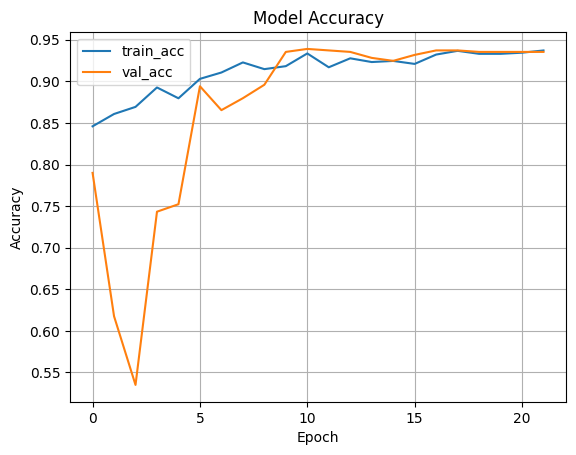

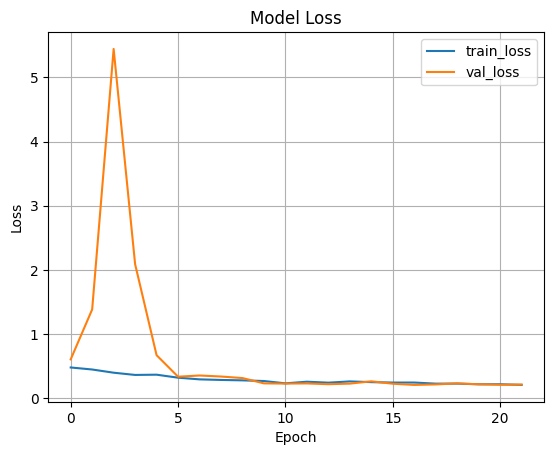

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
